<a href="https://colab.research.google.com/gist/HastingsGreer/17bda4bd8b22130266cb7b27121d65ec/ucf101fmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tfds-nightly tensorflow matplotlib


     |████████████████████████████████| 4.0 MB 8.4 MB/s 


In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [3]:
ds = tfds.load('davis', split='train', shuffle_files=True, try_gcs=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60 [00:00<?, ? examples/s]

Shuffling davis-train.tfrecord...:   0%|          | 0/60 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/30 [00:00<?, ? examples/s]

Shuffling davis-validation.tfrecord...:   0%|          | 0/30 [00:00<?, ? examples/s]

Dataset davis downloaded and prepared to /root/tensorflow_datasets/davis/480p/2.1.0. Subsequent calls will reuse this data.


In [12]:
BATCH_SIZE = 4 * strategy.num_replicas_in_sync # Gobal batch size.
# The global batch size will be automatically sharded across all
# replicas by the tf.data.Dataset API. A single TPU has 8 cores.
# The best practice is to scale the batch size by the number of
# replicas (cores). The learning rate should be increased as well.

LEARNING_RATE = 0.0001
LEARNING_RATE_EXP_DECAY = 1# = 0.6 if strategy.num_replicas_in_sync == 1 else 0.7
# Learning rate computed later as LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch
# 0.7 decay instead of 0.6 means a slower decay, i.e. a faster learnign rate.

SCALE = 1
SIDE_LENGTH = 90
def videoToPairDataset(video):
  video = video["video"]["frames"]
  frame_stride = 6
  inner_ds_A = tf.data.Dataset.from_tensor_slices(video[0:-frame_stride:frame_stride, ::4, :480:4])
  inner_ds_B = tf.data.Dataset.from_tensor_slices(video[frame_stride::frame_stride, ::4, :480:4])
  inner_ds = tf.data.Dataset.zip((inner_ds_A, inner_ds_B))
  return inner_ds
ds_f = ds.interleave(videoToPairDataset, cycle_length=10)
#df_f = ds_f.cache()
ds_f = ds_f.shuffle(buffer_size=800)
ds_f = ds_f.repeat()
ds_f = ds_f.batch(BATCH_SIZE, drop_remainder=True)
ds_f = ds_f.map(lambda x, y: ((x, y),x))
ds_f = ds_f.prefetch(-1)




In [13]:
q = iter(ds_f)


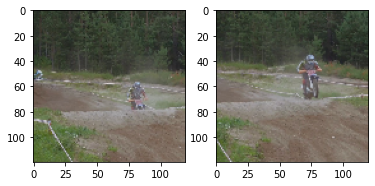

In [14]:
import matplotlib.pyplot as plt
a = next(q)
plt.subplot(1, 2, 1)
plt.imshow(a[0][0][0])
plt.subplot(1, 2, 2)
plt.imshow(a[0][1][0])

In [15]:
def make_model():
    model = tf.keras.Sequential(
      [
        
        #tf.keras.layers.ZeroPadding2D(padding=(15, 15), input_shape=(SIDE_LENGTH, SIDE_LENGTH, 1)),
        
        tf.keras.layers.Conv2D(filters=64, kernel_size=11, padding='valid', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm

        tf.keras.layers.Conv2D(filters=64, kernel_size=11, padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),

        tf.keras.layers.Conv2D(filters=64, kernel_size=11, padding='valid', use_bias=False),
        tf.keras.layers.BatchNormalization(scale=False, center=True),
        tf.keras.layers.Activation('relu'),
       
        tf.keras.layers.Conv2D(filters=512, kernel_size=1, padding='valid', use_bias=False), # no bias necessary before batch norm
        tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        tf.keras.layers.Activation('relu'), # activation after batch norm
       
        tf.keras.layers.Conv2D(filters=64, kernel_size=1, padding='valid', use_bias=False), # no bias necessary before batch norm
        #tf.keras.layers.BatchNormalization(scale=False, center=True), # no batch norm scaling necessary before "relu"
        #tf.keras.layers.Activation('relu'), # activation after batch norm
      ])
    
    input_A = tf.keras.Input(shape=(SIDE_LENGTH + 30, SIDE_LENGTH + 30, 3))
    input_B = tf.keras.Input(shape=(SIDE_LENGTH + 30, SIDE_LENGTH + 30, 3))
    features_A = model(input_A)
    features_B = model(input_B)

    features_A = tf.keras.layers.Reshape(target_shape=(SIDE_LENGTH * SIDE_LENGTH, 64))(features_A)
    features_B = tf.keras.layers.Reshape(target_shape=(SIDE_LENGTH * SIDE_LENGTH, 64))(features_B)

    cc = tf.keras.layers.Lambda(lambda var: tf.linalg.matmul(var[0], var[1], transpose_b=True), name="matmul")([features_A, features_B])

    cc_A = tf.keras.layers.Softmax(axis=-1)(cc)
    cc_B = tf.keras.layers.Softmax(axis=-2)(cc)

    loss = tf.keras.layers.Multiply()([cc_A, cc_B])

    loss = tf.keras.layers.Lambda(lambda var: tf.clip_by_value(var, 0, .3), name="clip")(loss)

    def fmapICON_clamp_loss(tensor, nonsense):
    
      return -tf.math.reduce_sum(nonsense) / BATCH_SIZE / SIDE_LENGTH / SIDE_LENGTH * strategy.num_replicas_in_sync

    outer_model = tf.keras.Model(inputs=(input_A, input_B), outputs=loss)

    outer_model.compile(optimizer='adam', # learning rate will be set by LearningRateScheduler
                  loss=fmapICON_clamp_loss)
    return outer_model
    
with strategy.scope():
    model = make_model()
# print model layers
model.summary()

# set up learning rate decay
lr_decay = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: LEARNING_RATE * LEARNING_RATE_EXP_DECAY**epoch,
    verbose=True)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 90, 90, 64)   1082112     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 8100, 64)     0           sequential_2[0][0]         

In [ ]:
EPOCHS = 60
steps_per_epoch = 60000//BATCH_SIZE  # 60,000 items in this dataset
print("Steps per epoch: ", steps_per_epoch)
  
history = model.fit(ds_f,
                    steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    callbacks=[lr_decay])

final_stats = model.evaluate(validation_dataset, steps=1)
print("Validation accuracy: ", final_stats[1])

Steps per epoch:  15000
Epoch 1/60

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
 1507/15000 [==>...........................] - ETA: 1:34:11 - loss: -0.1473